# NEU502a (Spring 2018)
## Problem Set #3: The Drift Diffusion Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import Categorical, DataFrame, concat
from scipy.stats import norm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.5)
%matplotlib inline

As mentioned in class, the drift-diffusion model has been a dominant model in understanding how decisions are made. The model predicts one makes a decision by integrating evidence over time. Part of the power of the driftdiffusion model is how simple it is. The dynamics are captured by:

$$ dC = v \cdot dt + w \cdot \mathcal{N}(0,1) $$

where $C$ is your decision variable, $v$ is the evidence that one is accumulating (the "drift"), and $w$ is the amount of noise in the integration (the "diffusion"). The initial condition is typically set to $C_0 = 0$ and the integration occurs to some bound $\pm B$, which initiates the choice. To get a better intuition for how the model works, we will simulate decision processes using the drift-diffusion model. 

**Problem 1**: Simulate a simple decision process using the drift-diffusion model. Parameters should be $C_0 = 0$, $B = 1$, $dt = 0.5$ ms, $v=2.5$, and $w=0.05$. 

1. Plot a few model runs, the percent of correct/incorrect trials, and the reaction time distributions for correct/incorrect trials. 
2. Describe why the model occasionally makes decision errors. Describe the shape of the reaction time distribution. Relate the shape of the reaction time distribution to human/animal behavioral responses.

**Problem 2**: If sensory evidence is increased (2x) or decreased (0.5x), how does this impact the decision process in the drift-diffusion model? 
1. Plot a few model runs, the percent of correct/incorrect trials, and the reaction time distributions for the baseline model, an increased-evidence model, and decreased-evidence model. 
2. Describe how you modeled a change in the sensory evidence.

**Problem 3**: Subjects appear to be able to trade accuracy for speed in most perceptual decision making tasks. The drift-diffusion model can capture this tradeoff in a simple manner. 
1. Plot a few model runs, the percent of correct/incorrect trials, and the reaction time distributions for the baseline model, an accuracy-biased model, and a speed-biased model.
2. Describe how you modeled the accuracy/speed tradeoff. Why is this a biologically plausible way of capturing this effect? b.

**Problem 4**: Using the original "baseline" model, if you examine the reaction time distributions for correct and error trials you'll notice that they are overlapping. However, in experiments, reaction times for incorrect trials are typically longer than for correct trials. To capture this effect, add some more variability across trials. Instead of a fixed $v$ for all trials, allow $v$ to vary across trials according to a normal distribution: $v = 2.5 + \mathcal{N}(0, 2.5)$.

1. Plot the reaction time distributions for both correct and incorrect trials. 
2. Describe the distributions as in #1. Does this better capture experimental observations? Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?

## Simulations
### The `ddm` function

In [2]:
def ddm(v, w, b=1, x0=0, dt=5e-4):
    '''Simulation of diffusion-to-bound model.
    
    Parameters
    ----------
    v : scalar
      drift rate
    w : scalar
      drift noise
    b : scalar
      boundary
    x0 : scalar
      initial evidence
    dt : scalar
      time step (in seconds)
      
    Returns
    -------
    c : int
      decision [lb = -1, ub = 1]
    z : scalar
      reaction time (in seconds)
    x : array
      evidence accumulated
    '''
    
    ## Initialize values.
    x = [x0]
    z = 0
    
    ## Drift-to-bound. 
    while np.abs(x[-1]) < b:
        x_prime = x[-1] + v * dt + w * np.random.normal(0,1)
        x.append( x_prime )
        z += dt
        
    ## Determine choice.
    if x[-1] > b: c = 1
    else: c = -1
        
    return c, z, np.array(x)

### Generate Data
To avoid code duplication, the data for each problem are simulated below. Justification for each model parameterization is given below.

In [3]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define stochastic drift function.
f = lambda: 2.5 + norm(0,2.5).rvs()

## Define sampling parameters.
n = 1000

## Define DDM parameters.
params = dict(Baseline   = dict(v=2.5,  w=0.05, b=1.0, x0=0, dt=5e-4),
              Strong     = dict(v=5.0,  w=0.05, b=1.0, x0=0, dt=5e-4),
              Weak       = dict(v=1.25, w=0.05, b=1.0, x0=0, dt=5e-4),
              Speed      = dict(v=2.5,  w=0.05, b=0.5, x0=0, dt=5e-4),
              Accuracy   = dict(v=2.5,  w=0.05, b=1.5, x0=0, dt=5e-4),
              Stochastic = dict(v=f,    w=0.05, b=1.0, x0=0, dt=5e-4) )
k = len(params)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Simulate data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space.
K = np.empty((k, n), dtype='U10')
C = np.zeros((k, n), dtype=float)
Z = np.zeros((k, n), dtype=float)
X = []

for i, kv in enumerate(params.items()):
    
    ## Extract condition and parameters.
    k, d = kv
    
    ## Iteratively simulate data.
    for j in np.arange(n):
        
        ## Sample v (if applicable.)
        if hasattr(d['v'], '__call__'): v = d['v']()
        else: v = d['v']
            
        ## Run DDM.
        c, z, x = ddm(v=v, w=d['w'], b=d['b'], dt=d['dt'], x0=d['x0'])

        ## Store values.
        K[i,j], C[i,j], Z[i,j] = k, c, z
        X.append(x)
    
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Postprocessing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
    
## Pad drift trajectories.
Xp = np.zeros((len(X), max(len(x) for x in X)))
for i, x in enumerate(X):
    Xp[i,:len(x)] = x
    Xp[i,len(x):] = np.nan

## Save memory (unnecessary).
X = Xp.copy()
del Xp
    
## Merge data in Pandas DataFrame.
data = DataFrame(np.vstack([C.flatten(),Z.flatten()]).T, columns=('Choice','RT'))
data['Choice'] = np.where(data['Choice'] > 0, 'Correct', 'Incorrect')
data['Condition'] = K.flatten()

## Sort by RT.
sort_ix = np.argsort(data.RT.values)
data = data.loc[sort_ix].reset_index(drop=True)
X = X[sort_ix]

## Problem 1: Baseline
### Visualization of results
#### Trace plots

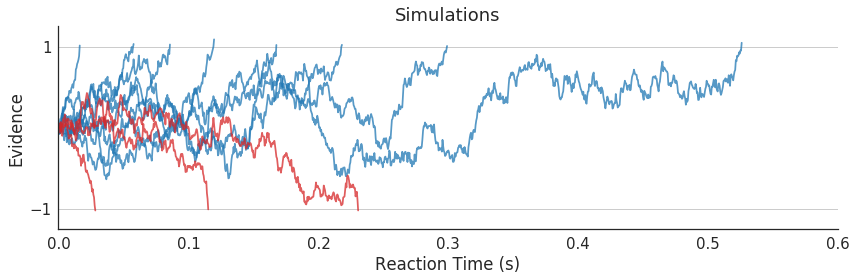

In [4]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Plotting.
for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
    ix, = np.where(np.logical_and(data.Condition=='Baseline', data.Choice==choice))
    ax.plot(X[ix[::100]].T, color=color, alpha=0.75)
    
## Add info.
xticks = ax.get_xticks()
ax.set(xlim=(-1), xticks=xticks, xticklabels=xticks*5e-4, xlabel='Reaction Time (s)', 
       ylim=(-1.25,1.25), yticks=[-1,1], ylabel='Evidence', title='Simulations')
ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

sns.despine()
plt.tight_layout()

#### Accuracy and reaction time plots

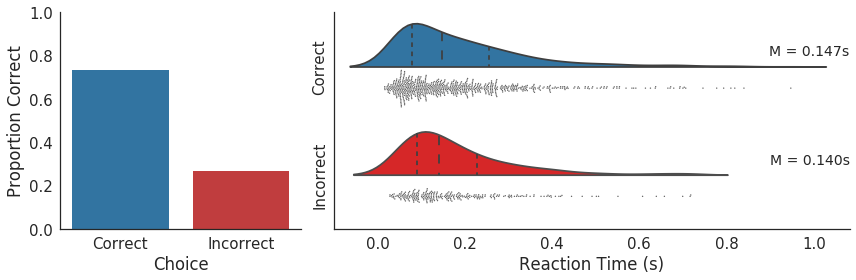

In [5]:
## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, 'Baseline')].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 
gb = df.groupby('Choice').RT.median()

## Plot percentages.
ax = plt.subplot2grid((1,3),(0,0))
sns.countplot('Choice', data=df, palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6),  ylabel='Proportion Correct',
            yticklabels=np.linspace(0,1,6).round(1))

## Plot RT distribution.
ax = plt.subplot2grid((1,3),(0,1),colspan=2)
df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
sns.violinplot('RT', 'Choice', 'hue', data=df, inner='quartile', split=True, ax=ax)
df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
sns.swarmplot('RT', 'Choice', 'hue', data=df, color='0.4', dodge=True, size=1.4, ax=ax)

## Add info.
ax.collections[1].set_color('#d62728')
ax.collections[1].set_edgecolor('0.3')
ax.set(xlim=(-0.1), xlabel='Reaction Time (s)', ylabel='')
ax.set_yticklabels(['Correct','Incorrect'], rotation=90, va='center')
ax.legend_.set_visible(False)

## Add text.
ax.annotate('M = %0.3fs' %gb['Correct'], (0,0), (1,0.8), 'axes fraction', fontsize=14, ha='right')
ax.annotate('M = %0.3fs' %gb['Incorrect'], (0,0), (1,0.3), 'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

### Description of results

*__Explain why the model occasionally makes decision errors.__*

Evidence accumulation (or drift diffusion) towards the positive bound, i.e. the "correct" response, is defined as a stochastic, noisy process. Though the drift is positively biased ($v > 0$), "incorrect" responses may still occur insofar that sufficient negative evidence is sampled randomly so as to cross the negative bound.

*__Describe the shape of the reaction time distribution. Relate the shape of the reaction time distribution to human/animal behavioral responses.__*

The reaction times (RT) for both correct and incorrect trials are characteristically right-skewed. In other words, the right tails of the RT distributions contain more mass than do the left tails. Skew is often exhibited by a difference between the mean and median of a distribution, where the mean is biased towards the skewed tail. We observe this pattern in RT distributions above such that the sample means are larger than the sample medians.

|         |Mean (ms)|Median (ms)|
|:-------:|:--:|:----:|
|Correct  |~190 |~150   |
|Incorrect|~180 |~140   |

Right-skew is a characteristic feature of human/animal reaction time distributions ([Ratcliff et al., 1999](http://star.psy.ohio-state.edu/html/wp/pdf/psychrev99.pdf); [Ratcliff & McKoon, 2009](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/)). Psychologically, right-skew reflects two features of information processing:

1. **Lower-bounds:** Sensory and motor processing prior to and after decision making is not instantaneous. As such, time to response has a hard lower boundary but no upper boundary, thereby resulting in bias towards longer reaction times.
2. **Costs:** Cognitive processes that improve decision making within-/across-trials (e.g. attention, motivation) are costly and effortful. As such, failures of attention/motivation are more likely than perfectly sustained attention/motivation, thereby resulting in bias towards longer reaction times.

## Problem 2: Strength of Evidence
### Visualization of results
#### Trace plots

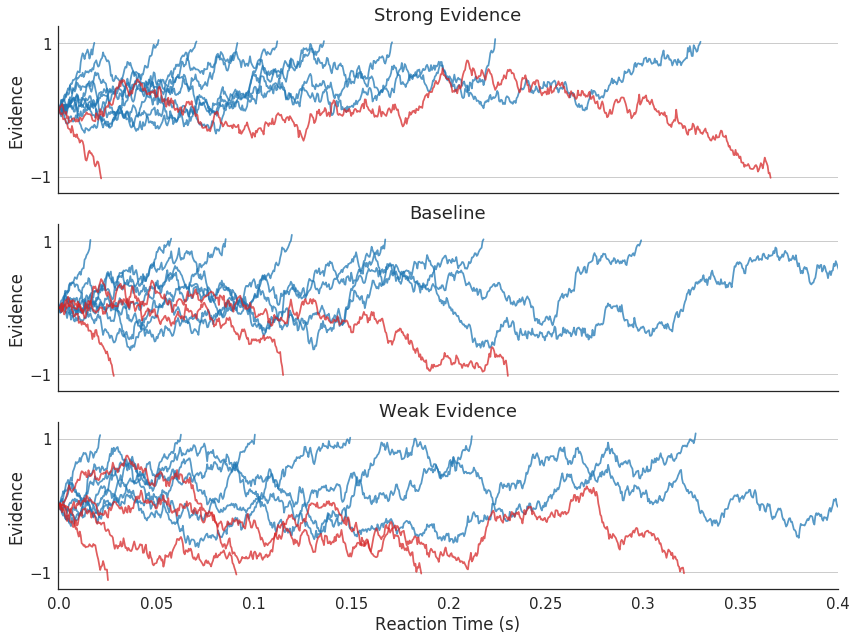

In [6]:
## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(12,9),sharex=True, sharey=True)

for ax, condition in zip(axes, ['Strong','Baseline','Weak']):
    
    ## Plotting.
    for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
        ix, = np.where(np.logical_and(data.Condition==condition, data.Choice==choice))
        ax.plot(X[ix[::100]].T, color=color, alpha=0.75)

    ## Add info.
    xticks = ax.get_xticks()
    title = '%s Evidence' %condition if not condition == 'Baseline' else condition
    ax.set(xlim=(-1), xticks=xticks, xticklabels=np.round(xticks*5e-4,2),  ylim=(-1.25,1.25), 
           yticks=[-1,1], ylabel='Evidence', title=title)
    ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

ax.set_xlabel('Reaction Time (s)')
sns.despine()
plt.tight_layout()

#### Accuracy plots

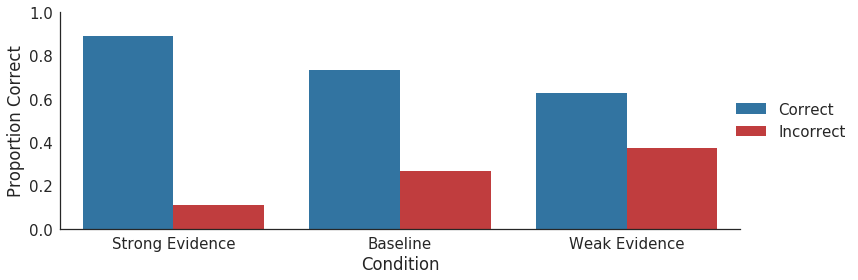

In [7]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Restrict data to conditions of interest.
order = ['Strong', 'Baseline', 'Weak']
df = data[np.in1d(data.Condition, order)].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 

## Plot.
sns.countplot('Condition', hue='Choice', data=df, order=order,
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), xticklabels=['Strong Evidence','Baseline','Weak Evidence'],
       yticks=np.linspace(0,n,6), yticklabels=np.linspace(0,1,6).round(1), 
       ylabel='Proportion Correct')
ax.legend(loc=7, bbox_to_anchor=(1.175,0.5))

sns.despine()
plt.tight_layout()

#### Reaction time plots

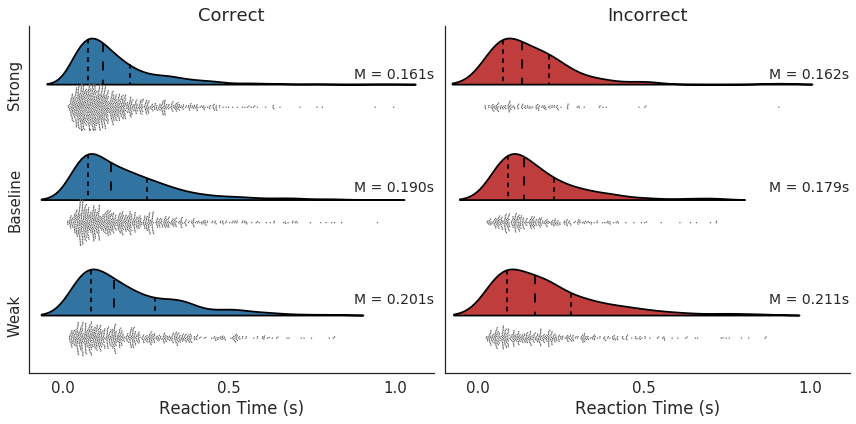

In [8]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

gb = df.groupby(['Choice','Condition']).RT.mean()
for ax, choice, color in zip(axes, ['Correct','Incorrect'], ['#1f77b4', '#d62728']):

    ## Plot RT distribution.
    df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
    sns.violinplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], order=order,
                   palette=[color,'k'], alpha=1, inner='quartile', split=True, ax=ax)
    df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
    sns.swarmplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], order=order,
                  color='0.4', dodge=True, size=1.4, ax=ax)

    ## Add info.
    ax.set(xlim=(-0.1), xticks=np.linspace(0,1,3), xlabel='Reaction Time (s)', 
           ylabel='', title=choice)
    ax.set_yticklabels(order, rotation=90, va='center')
    ax.legend_.set_visible(False)
    
    ## Add text.
    for y, condition in zip([0.85,0.525,0.2], order):
        ax.annotate('M = %0.3fs' %gb[choice,condition], (0,0), (1,y), 
                    'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

### Description of results

*__Describe how you modeled a change in the sensory evidence. How does this impact the decision process in the drift-diffusion model?__*

One way of modeling a change in the sensory evidence is through changing the drift rate. The intuition here is that, if the strength of evidence for some choice is increased or decreased, then the rate of evidence accumulation towards that choice should correspondingly increase or decrease. Thus, to model this change we doubled ($V = 5$) and halved ($V = 1.25$) the drift rate.

As is expected and observed above, changing the sensory evidence had the following effects: Increasing the sensory evidence (1) increased the proportion of correct-to-incorrect trials, and (2) decreased the median reaction time. Conversely, decreasing the sensory evidence (1) decreased the proportion of correct-to-incorrect trials, and (2) increased the median reaction time.

## Problem 3: Speed-Accuracy Tradeoff
### Visualization of results
#### Trace plots

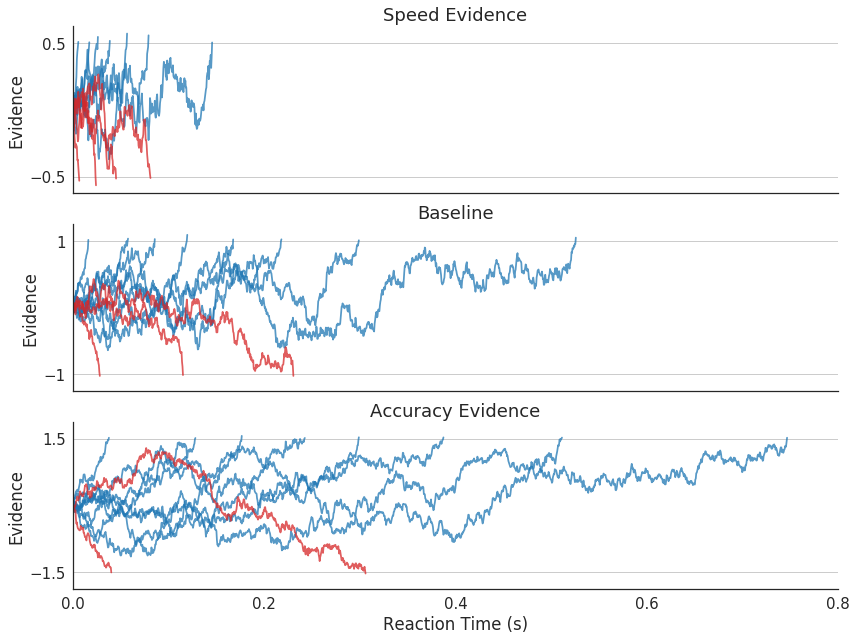

In [9]:
## Initialize canvas.
fig, axes = plt.subplots(3,1,figsize=(12,9), sharex=True)

for ax, condition, b in zip(axes, ['Speed', 'Baseline', 'Accuracy'], [0.5,1.0,1.5]):
    
    ## Plotting.
    for choice, color in zip(['Correct','Incorrect'], ['#1f77b4', '#d62728']):
        ix, = np.where(np.logical_and(data.Condition==condition, data.Choice==choice))
        ax.plot(X[ix[::100]].T, color=color, alpha=0.75)

    ## Add info.
    xticks = np.linspace(0,1600,5)
    title = '%s Evidence' %condition if not condition == 'Baseline' else condition
    ax.set(xlim=(-1), xticks=xticks, xticklabels=xticks*5e-4, ylim=(-b*1.25, b*1.25), 
           yticks=[-b,b], ylabel='Evidence', title=title)
    ax.grid(axis='y', color='k', alpha=0.2, zorder=0)

ax.set_xlabel('Reaction Time (s)')
sns.despine()
plt.tight_layout()

#### Accuracy plots

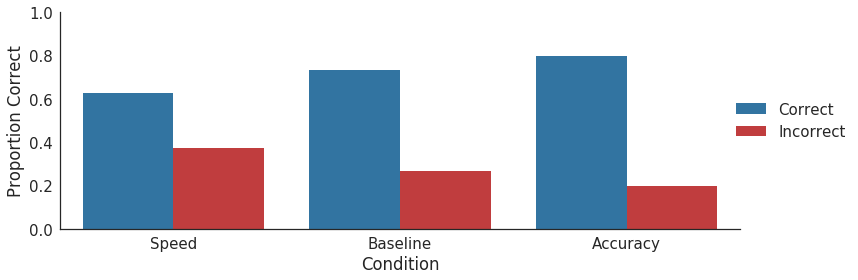

In [10]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(12,4))

## Restrict data to conditions of interest.
order = ['Speed', 'Baseline', 'Accuracy']
df = data[np.in1d(data.Condition, order)].copy()
df.loc[df.RT > 1, 'RT'] = np.nan 

## Plot.
sns.countplot('Condition', hue='Choice', data=df, order=order,
              palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6), ylabel='Proportion Correct',
       yticklabels=np.linspace(0,1,6).round(1))
ax.legend(loc=7, bbox_to_anchor=(1.175,0.5))

sns.despine()
plt.tight_layout()

#### Reaction time plots

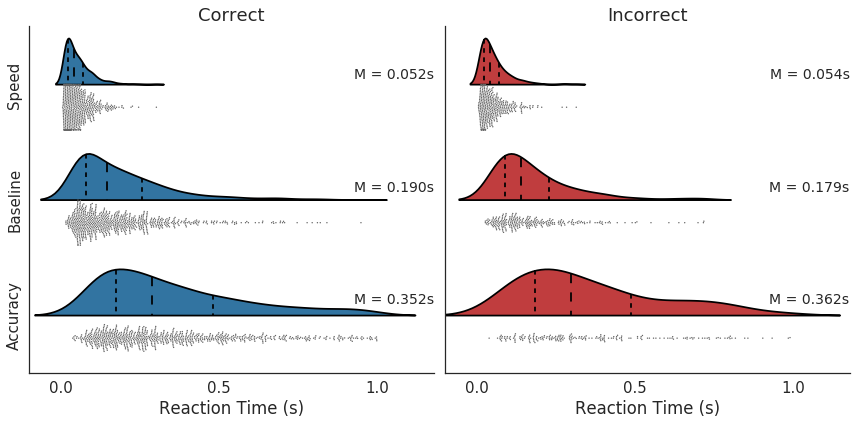

In [11]:
## Initialize canvas.
fig, axes = plt.subplots(1,2,figsize=(12,6),sharex=True,sharey=True)

gb = df.groupby(['Choice','Condition']).RT.mean()
for ax, choice, color in zip(axes, ['Correct','Incorrect'], ['#1f77b4', '#d62728']):

    ## Plot RT distribution.
    df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
    sns.violinplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], order=order,
                   palette=[color,'k'], alpha=1, inner='quartile', split=True, ax=ax)
    df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
    sns.swarmplot('RT', 'Condition', 'hue', data=df[df.Choice==choice], order=order,
                  color='0.4', dodge=True, size=1.4, ax=ax)

    ## Add info.
    ax.set(xlim=(-0.1), xticks=np.linspace(0,1,3), xlabel='Reaction Time (s)', 
           ylabel='', title=choice)
    ax.set_yticklabels(order, rotation=90, va='center')
    ax.legend_.set_visible(False)
    
    ## Add text.        
    for y, condition in zip([0.85,0.525,0.2], order):
        ax.annotate('M = %0.3fs' %gb[choice,condition], (0,0), (1,y), 
                    'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()

### Description of results
*__Describe how you modeled the accuracy/speed trade-off.__*

The boundary parameter, $B$, sets the thresholds for level of evidence necessary to initiate a response. Lowering the boundary, i.e. requiring less evidence for decision, amounts to decreasing response time (i.e. evidence accumulation time is shortened) at the expense of accuracy (i.e. noise less likely to be integrated out). Increasing the boundary, i.e. requiring more evidence, amounts to increasing response time (i.e. evidence accumulation time is prolonged) with the benefit of accuracy (i.e. noise more likely to be integrated out). 

Thus, modulating the decision boundary should capture the speed/accuracy trade-off. The simulations above the boundary was increased (accuracy, $B=1.5$) and decreased (speed, $B=0.5$).  The results of the simulations illustrate the predictions above.

*__Why is this a biologically plausible way of capturing this effect?__*

Roughly speaking, the circuitry of the striatum can be divided into two pathways: the go pathway, mediated by D1 dopaminergic neurons, and the no-go pathway, mediated by D2 dopaminergic neurons. These distinct pathways have opposite effects on motor control: activity in the former increases the likelihood of response, whereas activity in the latter decreases the likelihood of response. Activity in these pathways are dynamic both within- and across-trials ([Lanciego et al., 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3543080/)). 

Speed/accuracy trade-offs may plausibly be subserved by these circuits. A body of literature supports the idea that cortico-basal ganglia networks modulate the relative balance of go/no-go pathway activity in the basal ganglia with the result of biasing decision making towards speed or accuracy in timed tasks ([Bogacz et a., 2010](https://www.sciencedirect.com/science/article/pii/S0166223609001556); [Forstmann et al., 2010](http://www.pnas.org/content/107/36/15916.long)).

## Problem 4: Stochastic Drift Rates
### Visualization of results
#### Accuracy and reaction time plots

RT(Incorrect - Correct): U = 3412231, p = 0.005


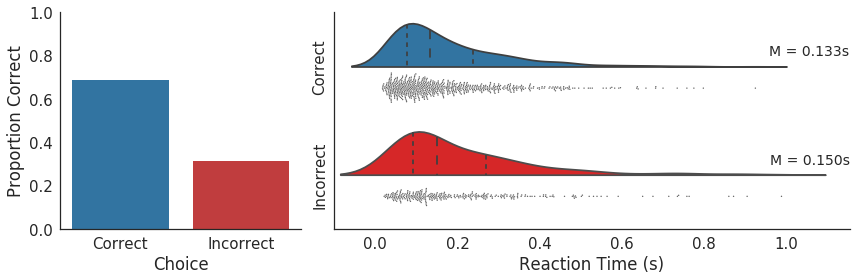

In [12]:
from scipy.stats import mannwhitneyu

## Initialize canvas.
fig = plt.figure(figsize=(12,4))

## Restrict data to conditions of interest.
df = data[np.in1d(data.Condition, 'Stochastic')].copy()

## Perform 2-sample t-test.
U, p = mannwhitneyu(data.loc[data.Choice=='Correct', 'RT'],
                    data.loc[data.Choice=='Incorrect', 'RT'])

df.loc[df.RT > 1, 'RT'] = np.nan 
gb = df.groupby('Choice').RT.median()

## Plot percentages.
ax = plt.subplot2grid((1,3),(0,0))
sns.countplot('Choice', data=df, palette=['#1f77b4', '#d62728'], ax=ax)
ax.set(ylim=(0,n), yticks=np.linspace(0,n,6),  ylabel='Proportion Correct',
            yticklabels=np.linspace(0,1,6).round(1))

## Plot RT distribution.
ax = plt.subplot2grid((1,3),(0,1),colspan=2)
df['hue'] = Categorical(np.zeros(df.shape[0]), categories=[0,1])
sns.violinplot('RT', 'Choice', 'hue', data=df, inner='quartile', split=True, ax=ax)
df['hue'] = Categorical(np.ones(df.shape[0]), categories=[0,1])
sns.swarmplot('RT', 'Choice', 'hue', data=df, color='0.4', dodge=True, size=1.4, ax=ax)

## Add info.
ax.collections[1].set_color('#d62728')
ax.collections[1].set_edgecolor('0.3')
ax.set(xlim=(-0.1), xlabel='Reaction Time (s)', ylabel='')
ax.set_yticklabels(['Correct','Incorrect'], rotation=90, va='center')
ax.legend_.set_visible(False)

## Add text.
ax.annotate('M = %0.3fs' %gb['Correct'], (0,0), (1,0.8), 'axes fraction', fontsize=14, ha='right')
ax.annotate('M = %0.3fs' %gb['Incorrect'], (0,0), (1,0.3), 'axes fraction', fontsize=14, ha='right')

sns.despine()
plt.tight_layout()
print('RT(Incorrect - Correct): U = %0.0f, p = %0.3f' %(U,p))

### Description of results
*__Describe the distributions. Does this better capture experimental observations?__*

Qualitatively, a stochastic drift rate yields proportionally longer reaction times during incorrect trials than for correct trials. A Mann–Whitney *U* test reveals this difference to be statistically significant. Thus, the model better captures the experimental observation that reaction times for incorrect trials are typically longer than for correct trials.

*__Provide an intuitive explanation for why there is now an increase in reaction time for error trials. Is this biologically plausible?__*

With normally distributed error on the drift rate, $V = \mathcal{N}(2.5,2.5)$, some non-negligible proportion of trials will be described by drift rates close to zero. Such trials are comparably more likely to result in error and in longer RTs. As such, the error trials observed in this model are likely to be longer in RT.

Stochasticity in drift rates is supported by studies of norepinephrine and reaction times in decision-making tasks ([Aston-Jones & Cohen, 2005](https://www.annualreviews.org/doi/abs/10.1146/annurev.neuro.28.061604.135709); [Kane et al., 2017](https://link.springer.com/article/10.3758/s13415-017-0531-y)). Phasic activity of noradrenergic neurons in the locus coeruleus during decision making predicts response times; specifically, larger phasic activity is predictive of increased accuracy and shorter reaction times. Computational models suggest that these findings are well described by trial-by-trial changes in drift rate ([Aston-Jones et al., 1999](https://www.ncbi.nlm.nih.gov/pubmed/10560036)). Thus, these studies demonstrate the biological plausibility drift rate stochasticity as mediated by noradrenergic circuitry.